In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Анализ Логики

### Предобработка

In [2]:
n = ['id', 'date', 'name', 'text', 'typr', 'rep', 'rtw', 'faw', 'stcount', 'foll', 'frien', 'listcount']
data_positive = pd.read_csv('data/positive.csv', sep=';', names=n, usecols=['text'])
data_negative = pd.read_csv('data/negative.csv', sep=';', names=n, usecols=['text'])
data_translated= pd.read_csv('data/translated.csv', sep=';',usecols=['text'])['text'].values
data_russian = np.concatenate((data_positive['text'].values[:20000],
                           data_negative['text'].values[:20000]), axis=0)#Поскольку датасет изначально русских текстов больше чем датасет берем первые 40000 его элементов

In [3]:
raw_data=np.concatenate((data_russian,data_translated),axis=0).astype(str)#Объединяем датасеты 
labels = [0] * len(data_russian)+[1]*len(data_translated)#Все переведенные фразы записываем в 'Нелогичные'(1) а те что изначально были на русском в логичные (0)

In [4]:
import re

def preprocess_text(text):
    text = text.lower().replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL', text)
    text = re.sub('@[^\s]+','USER', text)
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +',' ', text)
    return text.strip()

data = [preprocess_text(t) for t in raw_data]#Предобработка текстов в датасете

In [22]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)#разбиение выборок на обучающую и тестовую

In [46]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

SENTENCE_LENGTH = 26
NUM = 100000

def get_sequences(tokenizer, x):
    sequences = tokenizer.texts_to_sequences(x)
    return pad_sequences(sequences, maxlen=SENTENCE_LENGTH)

tokenizer = Tokenizer(num_words=NUM)
tokenizer.fit_on_texts(x_train)

x_train_seq = get_sequences(tokenizer, x_train)
x_test_seq = get_sequences(tokenizer, x_test)

In [7]:
from gensim.models import Word2Vec

w2v_model = Word2Vec.load('./w2v/tweets_model.w2v')

In [8]:
DIM = w2v_model.vector_size 
embedding_matrix = np.zeros((NUM, DIM))
for word, i in tokenizer.word_index.items():
    if i >= NUM:
        break
    if word in w2v_model.wv.index_to_key:
        embedding_matrix[i] = w2v_model.wv[word]

### Модель

In [9]:
from keras.layers import Input
from tensorflow.keras.layers import Embedding
import tensorflow as tf


In [10]:
from keras import backend as K


def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [11]:
import keras
from keras import optimizers
from keras.layers import Dense, concatenate, Activation, Dropout
from keras.models import Model
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import GlobalMaxPooling1D



In [12]:
    
tweet_input = Input(shape=(SENTENCE_LENGTH,), dtype='int32')
tweet_encoder = Embedding(NUM, DIM, input_length=SENTENCE_LENGTH,
                          weights=[embedding_matrix], trainable=False)(tweet_input)
branches = []
x = Dropout(0.2)(tweet_encoder)

for size, filters_count in [(2, 10), (3, 10), (4, 10), (5, 10)]:
    for i in range(filters_count):
        branch = Conv1D(filters=1, kernel_size=size, padding='valid', activation='relu')(x)
        branch = GlobalMaxPooling1D()(branch)
        branches.append(branch)
x = concatenate(branches, axis=1)
x = Dropout(0.2)(x)
x = Dense(30, activation='relu')(x)
x = Dense(1)(x)
output = Activation('sigmoid')(x)


## Обучение на одном узле

In [20]:
model_L = Model(inputs=[tweet_input], outputs=[output])
model_L.compile(
      optimizer= keras.optimizers.SGD(learning_rate=0.1),#keras.optimizers.Adam(),
      loss='binary_crossentropy',
      metrics=[precision, recall, f1]
  )

In [25]:
x_train_seq = np.array(x_train_seq)
y_train = np.array(y_train)

In [26]:
history = model_L.fit(x_train_seq, y_train, batch_size=32, epochs=10, validation_split=0.25)

Epoch 1/10
1500/1500 [==============================] - 267s 161ms/step - loss: 0.2580 - precision: 0.8871 - recall: 0.9025 - f1: 0.8915 - val_loss: 0.1840 - val_precision: 0.9068 - val_recall: 0.9516 - val_f1: 0.9264
Epoch 2/10
1500/1500 [==============================] - 93s 62ms/step - loss: 0.2523 - precision: 0.8840 - recall: 0.9077 - f1: 0.8924 - val_loss: 0.1837 - val_precision: 0.9102 - val_recall: 0.9472 - val_f1: 0.9261
Epoch 3/10
1500/1500 [==============================] - 90s 60ms/step - loss: 0.2504 - precision: 0.8882 - recall: 0.9040 - f1: 0.8927 - val_loss: 0.2022 - val_precision: 0.8912 - val_recall: 0.9588 - val_f1: 0.9215
Epoch 4/10
1500/1500 [==============================] - 91s 60ms/step - loss: 0.2483 - precision: 0.8885 - recall: 0.9073 - f1: 0.8946 - val_loss: 0.1935 - val_precision: 0.8998 - val_recall: 0.9501 - val_f1: 0.9220
Epoch 5/10
1500/1500 [==============================] - 93s 62ms/step - loss: 0.2473 - precision: 0.8878 - recall: 0.9083 - f1: 0.8947

## Обучение на 10 узлах

In [14]:
nodes = 10
logic = []

In [15]:
for i in range(nodes):
  logic.append(Model(inputs=[tweet_input], outputs=[output]))
  logic[i].compile(
      optimizer= keras.optimizers.SGD(learning_rate=0.1),#keras.optimizers.Adam(),
      loss='binary_crossentropy',
      metrics=[precision, recall, f1],
  )

In [18]:
x_train_split=np.array_split(x_train_seq, nodes)
y_train_split=np.array_split(y_train, nodes)

In [19]:
for i in range(40):  #epocs
  print('epoch number', i+1)
  w = []
  for j in range(nodes): #models
    print('model number', j+1)
    logic[j].fit(x_train_split[j], y_train_split[j], batch_size=32, epochs=1, validation_split=0.25)
    w.append(logic[j].get_weights())
  for j in range(nodes): #обмен весами model
    weigth = logic[j].get_weights()
    for h in range (len(w[0])):
      w[(j + 1)%nodes][h] += weigth[h]
      w[(j + 2)%nodes][h] += weigth[h]
  for j in range(nodes): 
    for h in range (len(w[0])):
      w[j][h] = w[j][h]/3
  for j in range(nodes):
    logic[j].set_weights(w[j])

epoch number 1
model number 1
150/150 [==============================] - 36s 176ms/step - loss: 0.6947 - precision: 0.5748 - recall: 0.5507 - f1: 0.5337 - val_loss: 0.5851 - val_precision: 0.6817 - val_recall: 0.5868 - val_f1: 0.6217
model number 2
150/150 [==============================] - 24s 122ms/step - loss: 0.5882 - precision: 0.6694 - recall: 0.7106 - f1: 0.6742 - val_loss: 0.5216 - val_precision: 0.6859 - val_recall: 0.8093 - val_f1: 0.7362
model number 3
150/150 [==============================] - 28s 137ms/step - loss: 0.5325 - precision: 0.7214 - recall: 0.7571 - f1: 0.7269 - val_loss: 0.4840 - val_precision: 0.7651 - val_recall: 0.8169 - val_f1: 0.7837
model number 4
150/150 [==============================] - 40s 217ms/step - loss: 0.5097 - precision: 0.7403 - recall: 0.7830 - f1: 0.7540 - val_loss: 0.4474 - val_precision: 0.8103 - val_recall: 0.8011 - val_f1: 0.8012
model number 5
150/150 [==============================] - 23s 112ms/step - loss: 0.4889 - precision: 0.7439 -

150/150 [==============================] - 40s 267ms/step - loss: 0.3025 - precision: 0.8512 - recall: 0.8839 - f1: 0.8631 - val_loss: 0.2721 - val_precision: 0.8455 - val_recall: 0.9190 - val_f1: 0.8792
model number 6
150/150 [==============================] - 7s 46ms/step - loss: 0.3108 - precision: 0.8575 - recall: 0.8752 - f1: 0.8620 - val_loss: 0.3021 - val_precision: 0.8116 - val_recall: 0.9555 - val_f1: 0.8736
model number 7
150/150 [==============================] - 6s 38ms/step - loss: 0.2953 - precision: 0.8712 - recall: 0.8901 - f1: 0.8772 - val_loss: 0.3066 - val_precision: 0.8390 - val_recall: 0.9209 - val_f1: 0.8758
model number 8
150/150 [==============================] - 6s 36ms/step - loss: 0.3041 - precision: 0.8578 - recall: 0.8837 - f1: 0.8652 - val_loss: 0.2973 - val_precision: 0.8216 - val_recall: 0.9339 - val_f1: 0.8702
model number 9
150/150 [==============================] - 8s 53ms/step - loss: 0.3088 - precision: 0.8539 - recall: 0.8871 - f1: 0.8665 - val_los

150/150 [==============================] - 7s 45ms/step - loss: 0.2820 - precision: 0.8591 - recall: 0.8933 - f1: 0.8727 - val_loss: 0.2485 - val_precision: 0.8519 - val_recall: 0.9296 - val_f1: 0.8864
model number 10
150/150 [==============================] - 46s 309ms/step - loss: 0.2687 - precision: 0.8785 - recall: 0.8918 - f1: 0.8811 - val_loss: 0.3150 - val_precision: 0.8066 - val_recall: 0.9257 - val_f1: 0.8580
epoch number 16
model number 1
150/150 [==============================] - 18s 120ms/step - loss: 0.2760 - precision: 0.8789 - recall: 0.8819 - f1: 0.8764 - val_loss: 0.2815 - val_precision: 0.8295 - val_recall: 0.9413 - val_f1: 0.8772
model number 2
150/150 [==============================] - 14s 95ms/step - loss: 0.2727 - precision: 0.8764 - recall: 0.8936 - f1: 0.8811 - val_loss: 0.2795 - val_precision: 0.8367 - val_recall: 0.9368 - val_f1: 0.8815
model number 3
150/150 [==============================] - 27s 182ms/step - loss: 0.2528 - precision: 0.8823 - recall: 0.9116 

150/150 [==============================] - 8s 55ms/step - loss: 0.2369 - precision: 0.8964 - recall: 0.8933 - f1: 0.8914 - val_loss: 0.3300 - val_precision: 0.8032 - val_recall: 0.9546 - val_f1: 0.8687
model number 4
150/150 [==============================] - 21s 139ms/step - loss: 0.2556 - precision: 0.8793 - recall: 0.8958 - f1: 0.8837 - val_loss: 0.2966 - val_precision: 0.8210 - val_recall: 0.9609 - val_f1: 0.8836
model number 5
150/150 [==============================] - 6s 41ms/step - loss: 0.2579 - precision: 0.8733 - recall: 0.9007 - f1: 0.8830 - val_loss: 0.2557 - val_precision: 0.8590 - val_recall: 0.9386 - val_f1: 0.8948
model number 6
150/150 [==============================] - 22s 143ms/step - loss: 0.2537 - precision: 0.8899 - recall: 0.9013 - f1: 0.8918 - val_loss: 0.2747 - val_precision: 0.8431 - val_recall: 0.9462 - val_f1: 0.8885
model number 7
150/150 [==============================] - 6s 37ms/step - loss: 0.2451 - precision: 0.8882 - recall: 0.8990 - f1: 0.8908 - val_l

150/150 [==============================] - 10s 66ms/step - loss: 0.2347 - precision: 0.8991 - recall: 0.9160 - f1: 0.9041 - val_loss: 0.2767 - val_precision: 0.8485 - val_recall: 0.9263 - val_f1: 0.8827
model number 8
150/150 [==============================] - 27s 175ms/step - loss: 0.2495 - precision: 0.8851 - recall: 0.9007 - f1: 0.8896 - val_loss: 0.2611 - val_precision: 0.8538 - val_recall: 0.9304 - val_f1: 0.8881
model number 9
150/150 [==============================] - 52s 347ms/step - loss: 0.2614 - precision: 0.8808 - recall: 0.8985 - f1: 0.8854 - val_loss: 0.2358 - val_precision: 0.8615 - val_recall: 0.9310 - val_f1: 0.8925
model number 10
150/150 [==============================] - 16s 108ms/step - loss: 0.2500 - precision: 0.8811 - recall: 0.9024 - f1: 0.8880 - val_loss: 0.2861 - val_precision: 0.8390 - val_recall: 0.9050 - val_f1: 0.8673
epoch number 31
model number 1
150/150 [==============================] - 20s 133ms/step - loss: 0.2429 - precision: 0.8978 - recall: 0.898

150/150 [==============================] - 47s 313ms/step - loss: 0.2392 - precision: 0.8910 - recall: 0.9149 - f1: 0.8995 - val_loss: 0.2505 - val_precision: 0.8694 - val_recall: 0.9176 - val_f1: 0.8894
model number 2
150/150 [==============================] - 14s 96ms/step - loss: 0.2507 - precision: 0.8849 - recall: 0.9034 - f1: 0.8908 - val_loss: 0.2977 - val_precision: 0.8130 - val_recall: 0.9585 - val_f1: 0.8781
model number 3
150/150 [==============================] - 5s 36ms/step - loss: 0.2234 - precision: 0.9003 - recall: 0.9091 - f1: 0.9022 - val_loss: 0.2912 - val_precision: 0.8397 - val_recall: 0.9278 - val_f1: 0.8785
model number 4
150/150 [==============================] - 27s 178ms/step - loss: 0.2248 - precision: 0.8979 - recall: 0.9127 - f1: 0.9025 - val_loss: 0.2805 - val_precision: 0.8597 - val_recall: 0.9402 - val_f1: 0.8961
model number 5
150/150 [==============================] - 15s 97ms/step - loss: 0.2304 - precision: 0.8979 - recall: 0.9095 - f1: 0.9007 - val

### Проверка модели

График ниже показывает значение функции потерь на обучающей и валидационной выборке,поскольку они не расходятся можно сделать вывод, что переобучения не произошло

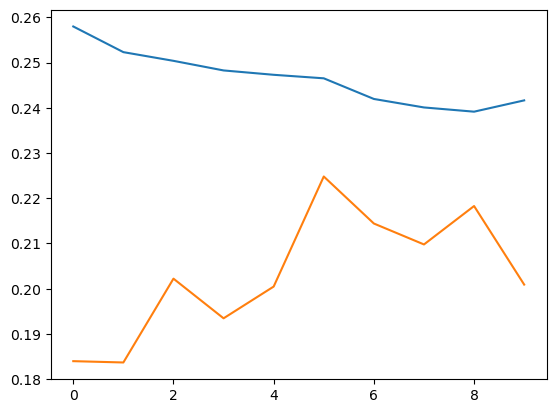

In [28]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

In [31]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

In [64]:
predicted1 = np.round(logic[1].predict(x_test_seq))
print(classification_report(y_test, predicted1, digits=6))

500/500 [==============================] - 8s 15ms/step
              precision    recall  f1-score   support

           0   0.909354  0.862858  0.885496      7999
           1   0.869514  0.913978  0.891192      7998

    accuracy                       0.888417     15997
   macro avg   0.889434  0.888418  0.888344     15997
weighted avg   0.889435  0.888417  0.888344     15997



In [63]:
predicted2 = np.round(model_L.predict(x_test_seq))
print(classification_report(y_test, predicted2, digits=6))

500/500 [==============================] - 23s 46ms/step
              precision    recall  f1-score   support

           0   0.909354  0.862858  0.885496      7999
           1   0.869514  0.913978  0.891192      7998

    accuracy                       0.888417     15997
   macro avg   0.889434  0.888418  0.888344     15997
weighted avg   0.889435  0.888417  0.888344     15997



# Анализ эмоций

### Предобработка

In [270]:
ekman_data=pd.read_csv('./data/ekman-translated.csv')

In [271]:
ekman_data = ekman_data.loc[(ekman_data['label'] == '0') | 
  (ekman_data['label'] == '1') | 
  (ekman_data['label'] == '2') |
  (ekman_data['label'] == '3') |
  (ekman_data['label'] == '4') | 
  (ekman_data['label'] == '5') | 
  (ekman_data['label'] == '6')]

In [272]:
ekman_data["label"].value_counts()

4    19020
0    16021
1     5420
6     4805
5     2875
3      693
2      635
Name: label, dtype: int64

In [273]:
dict1={'0':'нейтрально','1':'злость','2':'отвращение','3':'страх','4':'радость','5':'грусть','6':'удивление'}

In [274]:
ekman_data=ekman_data.replace({"label": dict1})

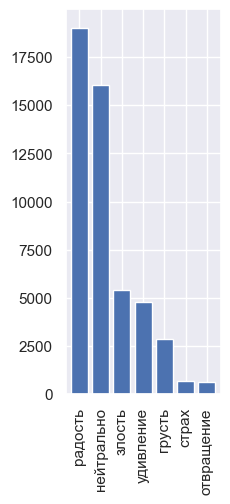

In [275]:
b=ekman_data["label"].value_counts()
import seaborn 
seaborn.set() 

df = pd.DataFrame(b.values, index=b.index)
df.plot(kind='bar', legend=False, width=0.8, figsize=(2,5))
plt.show()

In [276]:
def get_rat(data,samp,max_samp='joy'):
    
    return rat

In [277]:
def upsmple(data,samp,max_samp='joy'):
    rat = len(data.loc[data['label']==max_samp])//len(data.loc[data['label']==samp])
    df_1 = data.loc[data['label']==samp]
    df_1 = df_1.loc[df_1.index.repeat(rat)]
    train_n = pd.concat([data.loc[data['label']!=samp], df_1]).sample(frac=1)
    return train_n

In [278]:
ekman_data=upsmple(ekman_data,samp='страх',max_samp='радость')
ekman_data=upsmple(ekman_data,samp='злость',max_samp='радость')
ekman_data=upsmple(ekman_data,samp='удивление',max_samp='радость')
ekman_data=upsmple(ekman_data,samp='грусть',max_samp='радость')
ekman_data=upsmple(ekman_data,samp='отвращение',max_samp='радость')

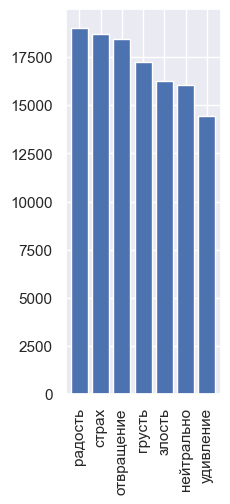

In [279]:
b=ekman_data["label"].value_counts()
import seaborn 
seaborn.set() 

df = pd.DataFrame(b.values, index=b.index)
df.plot(kind='bar', legend=False, width=0.8, figsize=(2,5))
plt.show()

In [280]:
x=ekman_data["text"].values.astype(str)
y=ekman_data.drop(['id','text','label'],axis=1).values

In [281]:
x = [preprocess_text(t) for t in x]

In [282]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [283]:
'''
model.compile(loss='binary_crossentropy', optimizer='adam', )
'''
from tensorflow.keras import activations
from tensorflow.keras.layers import Activation 
from tensorflow.keras.layers import BatchNormalization

    
tweet_input = Input(shape=(SENTENCE_LENGTH,), dtype='int32')
tweet_encoder = Embedding(NUM, DIM, input_length=SENTENCE_LENGTH,
                          weights=[embedding_matrix], trainable=False)(tweet_input)
# x = Dropout(0.2)(tweet_encoder)
x = tweet_encoder
branches = []
for size, filters_count in [(2, 10), (3, 10), (4, 10), (5, 10)]:
    for i in range(filters_count):
        branch = Conv1D(filters=1, kernel_size=size, padding='valid', activation=tf.keras.layers.LeakyReLU(alpha=0.01))(x)
        branch = GlobalMaxPooling1D()(branch)
        branches.append(branch)
x = concatenate(branches, axis=1)
# x = Dropout(0.5)(x)

x = Dense(256)(x) # 'relu'
x = BatchNormalization()(x) 
x = Activation('leaky_relu')(x)
x = Dropout(0.3)(x)

x = Dense(256)(x) # 'relu'
x = BatchNormalization()(x) 
x = Activation('leaky_relu')(x)
x = Dropout(0.3)(x)

x = Dense(64)(x)
x = BatchNormalization()(x) 
x = Activation('leaky_relu')(x)
x = Dropout(0.3)(x)

x = Dense(7)(x)#В отличе от предыдущего слоя в этом 7 выходных нейронов,по числу классов
output = Activation('softmax')(x)



### Обучение на одном узле

In [181]:
model_S = Model(inputs=[tweet_input], outputs=[output])
model_S.compile(
      optimizer= keras.optimizers.SGD(learning_rate=0.1),#keras.optimizers.Adam(),
      loss='categorical_crossentropy',
      metrics=[precision, recall, f1], 
  )

In [202]:
x_train_seq=get_sequences(tokenizer, x_train)
x_test_seq=get_sequences(tokenizer, x_test)

In [286]:
model_S.fit(x_train_seq, y_train, batch_size=256, epochs=40, validation_split=0.25)

Epoch 1/40
282/282 [==============================] - 310s 1s/step - loss: 1.6599 - precision: 0.6419 - recall: 0.1430 - f1: 0.2283 - val_loss: 1.2303 - val_precision: 0.8117 - val_recall: 0.3249 - val_f1: 0.4636
Epoch 2/40
282/282 [==============================] - 285s 1s/step - loss: 1.1262 - precision: 0.8171 - recall: 0.3902 - f1: 0.5267 - val_loss: 1.0114 - val_precision: 0.8116 - val_recall: 0.4684 - val_f1: 0.5935
Epoch 3/40
282/282 [==============================] - 268s 951ms/step - loss: 0.9438 - precision: 0.8403 - recall: 0.4856 - f1: 0.6150 - val_loss: 0.9256 - val_precision: 0.8255 - val_recall: 0.5012 - val_f1: 0.6235
Epoch 4/40
282/282 [==============================] - 255s 905ms/step - loss: 0.8614 - precision: 0.8445 - recall: 0.5336 - f1: 0.6537 - val_loss: 0.8984 - val_precision: 0.8128 - val_recall: 0.5344 - val_f1: 0.6446
Epoch 5/40
282/282 [==============================] - 242s 859ms/step - loss: 0.8070 - precision: 0.8469 - recall: 0.5659 - f1: 0.6782 - val_l

Epoch 39/40
282/282 [==============================] - 239s 847ms/step - loss: 0.3956 - precision: 0.8895 - recall: 0.8215 - f1: 0.8541 - val_loss: 0.9045 - val_precision: 0.7770 - val_recall: 0.7122 - val_f1: 0.7431
Epoch 40/40
282/282 [==============================] - 240s 850ms/step - loss: 0.3945 - precision: 0.8883 - recall: 0.8224 - f1: 0.8540 - val_loss: 0.6536 - val_precision: 0.8236 - val_recall: 0.7625 - val_f1: 0.7918


In [203]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model_S.evaluate(x_test_seq, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
188/188 [==============================] - 3s 16ms/step - loss: 0.4185 - precision: 0.8746 - recall: 0.8246 - f1: 0.8487
test loss, test acc: [0.41852882504463196, 0.8746042251586914, 0.8245611786842346, 0.8487429618835449]


### Обучение на 10 узлах

In [249]:
nodes = 10
sentiment = []

In [250]:
for i in range(nodes):
  sentiment.append(Model(inputs=[tweet_input], outputs=[output]))
  sentiment[i].compile(
      optimizer= keras.optimizers.SGD(learning_rate=0.1),#keras.optimizers.Adam(),
      loss='categorical_crossentropy',
      metrics=[precision, recall, f1], 
  )

In [251]:
x_train_split=np.array_split(x_train_seq, nodes)
y_train_split=np.array_split(y_train, nodes)

In [252]:
for i in range(80):  #epocs
  print('epoch number', i+1)
  w = []
  for j in range(nodes): #models
    print('model number', j+1)
    sentiment[j].fit(x_train_split[j], y_train_split[j], batch_size=256, epochs=1, validation_split=0.25)
    w.append(sentiment[j].get_weights())
  for j in range(nodes): #обмен весами model
    weigth = sentiment[j].get_weights()
    for h in range (len(w[0])):
      w[(j + 1)%nodes][h] += weigth[h]
      w[(j + 2)%nodes][h] += weigth[h]
  for j in range(nodes): 
    for h in range (len(w[0])):
      w[j][h] = w[j][h]/3
  for j in range(nodes):
    sentiment[j].set_weights(w[j])

epoch number 1
model number 1
29/29 [==============================] - 51s 1s/step - loss: 4.8033 - precision: 0.1397 - recall: 0.0718 - f1: 0.0877 - val_loss: 2.7904 - val_precision: 0.1362 - val_recall: 0.0221 - val_f1: 0.0379
model number 2
29/29 [==============================] - 50s 1s/step - loss: 2.2283 - precision: 0.1075 - recall: 0.0073 - f1: 0.0135 - val_loss: 2.1518 - val_precision: 0.2075 - val_recall: 0.0048 - val_f1: 0.0093
model number 3
29/29 [==============================] - 49s 1s/step - loss: 2.0639 - precision: 0.1690 - recall: 0.0032 - f1: 0.0063 - val_loss: 2.0471 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
model number 4
29/29 [==============================] - 50s 1s/step - loss: 2.0129 - precision: 0.1456 - recall: 0.0027 - f1: 0.0053 - val_loss: 2.0011 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
model number 5
29/29 [==============================] - 50s 1s/step - loss: 2.0015 - precision: 0.2063 - 

model number 6
29/29 [==============================] - 27s 923ms/step - loss: 1.9506 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1: 0.0000e+00 - val_loss: 1.9477 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
model number 7
29/29 [==============================] - 32s 1s/step - loss: 1.9480 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1: 0.0000e+00 - val_loss: 1.9460 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
model number 8
29/29 [==============================] - 29s 991ms/step - loss: 1.9473 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1: 0.0000e+00 - val_loss: 1.9473 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
model number 9
29/29 [==============================] - 28s 968ms/step - loss: 1.9495 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1: 0.0000e+00 - val_loss: 1.9448 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
model number 10
29/29 [================

KeyboardInterrupt: 

# Отбор текста для проекта

In [47]:
def prepareText(text,tokenizer):
    text_seq = get_sequences(tokenizer, [text])
    return text_seq,text

In [295]:
fullTexts = []

In [296]:
f = open('./data/FullDataset.txt', encoding='utf-8')

for line in f:
    fullTexts.append([line])
fullTexts

[['\ufeffНейросети применяются в области компьютерного зрения для распознавания и классификации изображений.\n'],
 ['В медицине нейросети используются для диагностики заболеваний и анализа медицинских изображений.\n'],
 ['Нейросети применяются в автономных автомобилях для распознавания дорожных знаков и прогнозирования движения.\n'],
 ['В финансовой сфере нейросети используются для прогнозирования рыночных трендов и анализа финансовых данных.\n'],
 ['Нейросети применяются в рекомендательных системах для персонализации рекомендаций и улучшения пользовательского опыта.\n'],
 ['В области естественного языка нейросети используются для автоматического перевода и анализа текстов.\n'],
 ['Нейросети применяются в робототехнике для управления роботами и выполнения сложных задач.\n'],
 ['В музыкальной индустрии нейросети используются для создания и композиции новых музыкальных треков.\n'],
 ['Нейросети применяются в игровой индустрии для создания умных и реалистичных виртуальных персонажей.\n'],

In [297]:
length = len(fullTexts)

In [298]:
for i in range(length):
    text_seq, text = prepareText(fullTexts[i][0], tokenizer)
    fullTexts[i].append(model_L.predict(text_seq)[0][0])
fullTexts

1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 40ms/step


[['\ufeffНейросети применяются в области компьютерного зрения для распознавания и классификации изображений.\n',
  0.11255009],
 ['В медицине нейросети используются для диагностики заболеваний и анализа медицинских изображений.\n',
  0.7143252],
 ['Нейросети применяются в автономных автомобилях для распознавания дорожных знаков и прогнозирования движения.\n',
  0.78431576],
 ['В финансовой сфере нейросети используются для прогнозирования рыночных трендов и анализа финансовых данных.\n',
  0.8191612],
 ['Нейросети применяются в рекомендательных системах для персонализации рекомендаций и улучшения пользовательского опыта.\n',
  0.9426776],
 ['В области естественного языка нейросети используются для автоматического перевода и анализа текстов.\n',
  0.38888586],
 ['Нейросети применяются в робототехнике для управления роботами и выполнения сложных задач.\n',
  0.74650246],
 ['В музыкальной индустрии нейросети используются для создания и композиции новых музыкальных треков.\n',
  0.87551135]

In [299]:
preFinalTexts = []

In [300]:
k = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

for i in range(length):
    if (fullTexts[i][1] >= 0 and fullTexts[i][1] < 0.1):
        k[0] += 1
    if (fullTexts[i][1] >= 0.1 and fullTexts[i][1] < 0.2):
        k[1] += 1
    if (fullTexts[i][1] >= 0.2 and fullTexts[i][1] < 0.3):
        k[2] += 1
    if (fullTexts[i][1] >= 0.3 and fullTexts[i][1] < 0.4):
        k[3] += 1
    if (fullTexts[i][1] >= 0.4 and fullTexts[i][1] < 0.5):
        k[4] += 1
    if (fullTexts[i][1] >= 0.5 and fullTexts[i][1] < 0.6):
        k[5] += 1
    if (fullTexts[i][1] >= 0.6 and fullTexts[i][1] < 0.7):
        preFinalTexts.append(fullTexts[i])
        k[6] += 1
    if (fullTexts[i][1] >= 0.7 and fullTexts[i][1] < 0.8):
        preFinalTexts.append(fullTexts[i])
        k[7] += 1
    if (fullTexts[i][1] >= 0.8 and fullTexts[i][1] < 0.9):
        preFinalTexts.append(fullTexts[i])
        k[8] += 1
    if (fullTexts[i][1] >= 0.9 and fullTexts[i][1] <= 1):
        preFinalTexts.append(fullTexts[i])
        k[9] += 1

print(k)

[33, 64, 44, 52, 70, 75, 134, 144, 190, 228]


In [301]:
preFinalTexts

[['В медицине нейросети используются для диагностики заболеваний и анализа медицинских изображений.\n',
  0.7143252],
 ['Нейросети применяются в автономных автомобилях для распознавания дорожных знаков и прогнозирования движения.\n',
  0.78431576],
 ['В финансовой сфере нейросети используются для прогнозирования рыночных трендов и анализа финансовых данных.\n',
  0.8191612],
 ['Нейросети применяются в рекомендательных системах для персонализации рекомендаций и улучшения пользовательского опыта.\n',
  0.9426776],
 ['Нейросети применяются в робототехнике для управления роботами и выполнения сложных задач.\n',
  0.74650246],
 ['В музыкальной индустрии нейросети используются для создания и композиции новых музыкальных треков.\n',
  0.87551135],
 ['Нейросети применяются в игровой индустрии для создания умных и реалистичных виртуальных персонажей.\n',
  0.87986463],
 ['Нейросети применяются в анализе данных климатических изменений и прогнозирования погоды.\n',
  0.80904204],
 ['Нейросети при

In [302]:
p = []

for i in k:
    p.append(round(i/length, 4))
p

[0.0319,
 0.0619,
 0.0426,
 0.0503,
 0.0677,
 0.0725,
 0.1296,
 0.1393,
 0.1838,
 0.2205]

In [304]:
for i in range(length):
    text_seq, text = prepareText(fullTexts[i][0], tokenizer)
    pred=model_S_test.predict([text_seq])
    fullTexts[i].append(dict1[str(np.argmax(pred))])
fullTexts

1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 49ms/step


[['\ufeffНейросети применяются в области компьютерного зрения для распознавания и классификации изображений.\n',
  0.11255009,
  'нейтрально'],
 ['В медицине нейросети используются для диагностики заболеваний и анализа медицинских изображений.\n',
  0.7143252,
  'нейтрально'],
 ['Нейросети применяются в автономных автомобилях для распознавания дорожных знаков и прогнозирования движения.\n',
  0.78431576,
  'нейтрально'],
 ['В финансовой сфере нейросети используются для прогнозирования рыночных трендов и анализа финансовых данных.\n',
  0.8191612,
  'отвращение'],
 ['Нейросети применяются в рекомендательных системах для персонализации рекомендаций и улучшения пользовательского опыта.\n',
  0.9426776,
  'нейтрально'],
 ['В области естественного языка нейросети используются для автоматического перевода и анализа текстов.\n',
  0.38888586,
  'нейтрально'],
 ['Нейросети применяются в робототехнике для управления роботами и выполнения сложных задач.\n',
  0.74650246,
  'нейтрально'],
 ['В му

In [305]:
k1 = [0, 0, 0, 0, 0, 0, 0]

#dict1={'0':'нейтрально','1':'злость','2':'отвращение','3':'страх','4':'радость','5':'грусть','6':'удивление'}

for i in range(length):
    if (fullTexts[i][2] == 'нейтрально'):
        k1[0] += 1
    if (fullTexts[i][2] == 'злость'):
        k1[1] += 1
    if (fullTexts[i][2] == 'отвращение'):
        k1[2] += 1
    if (fullTexts[i][2] == 'страх'):
        k1[3] += 1
    if (fullTexts[i][2] == 'радость'):
        k1[4] += 1
    if (fullTexts[i][2] == 'грусть'):
        k1[5] += 1
    if (fullTexts[i][2] == 'удивление'):
        k1[6] += 1
k1

[621, 59, 16, 19, 198, 66, 55]

In [306]:
p1 = []

for i in k1:
    p1.append(round(i/length, 4))
p1

[0.6006, 0.0571, 0.0155, 0.0184, 0.1915, 0.0638, 0.0532]

In [307]:
for i in range(len(preFinalTexts)):
    text_seq, text = prepareText(preFinalTexts[i][0], tokenizer)
    pred=model_S_test.predict([text_seq])
    preFinalTexts[i].append(dict1[str(np.argmax(pred))])
preFinalTexts

1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 51ms/step


[['В медицине нейросети используются для диагностики заболеваний и анализа медицинских изображений.\n',
  0.7143252,
  'нейтрально',
  'нейтрально'],
 ['Нейросети применяются в автономных автомобилях для распознавания дорожных знаков и прогнозирования движения.\n',
  0.78431576,
  'нейтрально',
  'нейтрально'],
 ['В финансовой сфере нейросети используются для прогнозирования рыночных трендов и анализа финансовых данных.\n',
  0.8191612,
  'отвращение',
  'отвращение'],
 ['Нейросети применяются в рекомендательных системах для персонализации рекомендаций и улучшения пользовательского опыта.\n',
  0.9426776,
  'нейтрально',
  'нейтрально'],
 ['Нейросети применяются в робототехнике для управления роботами и выполнения сложных задач.\n',
  0.74650246,
  'нейтрально',
  'нейтрально'],
 ['В музыкальной индустрии нейросети используются для создания и композиции новых музыкальных треков.\n',
  0.87551135,
  'нейтрально',
  'нейтрально'],
 ['Нейросети применяются в игровой индустрии для создания

In [308]:
length1 = len(preFinalTexts)

In [309]:
finalTexts = []

In [310]:
k2 = [0, 0, 0, 0, 0, 0, 0]

#dict1={'0':'нейтрально','1':'злость','2':'отвращение','3':'страх','4':'радость','5':'грусть','6':'удивление'}

for i in range(len(preFinalTexts)):
    if (preFinalTexts[i][2] == 'нейтрально'):
        finalTexts.append(preFinalTexts[i])
        k2[0] += 1
    if (preFinalTexts[i][2] == 'злость'):
        k2[1] += 1
    if (preFinalTexts[i][2] == 'отвращение'):
        k2[2] += 1
    if (preFinalTexts[i][2] == 'страх'):
        k2[3] += 1
    if (preFinalTexts[i][2] == 'радость'):
        finalTexts.append(preFinalTexts[i])
        k2[4] += 1
    if (preFinalTexts[i][2] == 'грусть'):
        k2[5] += 1
    if (preFinalTexts[i][2] == 'удивление'):
        finalTexts.append(preFinalTexts[i])
        k2[6] += 1
k2

[390, 46, 11, 13, 151, 53, 32]

In [311]:
p2 = []

for i in k2:
    p2.append(round(i/length1, 4))
p2

[0.5603, 0.0661, 0.0158, 0.0187, 0.217, 0.0761, 0.046]

In [222]:
for i in range(len(finalTexts)):
    print(finalTexts[i][0])

В медицине нейросети используются для диагностики заболеваний и анализа медицинских изображений.

Нейросети применяются в автономных автомобилях для распознавания дорожных знаков и прогнозирования движения.

В финансовой сфере нейросети используются для прогнозирования рыночных трендов и анализа финансовых данных.

Нейросети применяются в рекомендательных системах для персонализации рекомендаций и улучшения пользовательского опыта.

Нейросети применяются в робототехнике для управления роботами и выполнения сложных задач.

В музыкальной индустрии нейросети используются для создания и композиции новых музыкальных треков.

Нейросети применяются в анализе данных климатических изменений и прогнозирования погоды.

Нейросети применяются в сфере сельского хозяйства для оптимизации производства и повышения урожайности.

Нейросети применяются в обработке и сжатии изображений и видео.

Нейросети применяются в сфере кибербезопасности для обнаружения и предотвращения кибератак.

В сфере фармацевтик

In [229]:
finalFile=open('finalFile.txt', 'w')

In [231]:
for element in finalTexts:
     finalFile.write(element[0])
     finalFile.write('\n')
finalFile.close()

In [262]:
for i in range(len(finalTexts)):
    finalTexts[i].pop()
    
finalTexts

[['В медицине нейросети используются для диагностики заболеваний и анализа медицинских изображений.\n',
  0.7143252,
  'нейтрально'],
 ['Нейросети применяются в автономных автомобилях для распознавания дорожных знаков и прогнозирования движения.\n',
  0.78431576,
  'нейтрально'],
 ['В финансовой сфере нейросети используются для прогнозирования рыночных трендов и анализа финансовых данных.\n',
  0.8191612,
  'нейтрально'],
 ['Нейросети применяются в рекомендательных системах для персонализации рекомендаций и улучшения пользовательского опыта.\n',
  0.9426776,
  'нейтрально'],
 ['Нейросети применяются в робототехнике для управления роботами и выполнения сложных задач.\n',
  0.74650246,
  'нейтрально'],
 ['В музыкальной индустрии нейросети используются для создания и композиции новых музыкальных треков.\n',
  0.87551135,
  'нейтрально'],
 ['Нейросети применяются в анализе данных климатических изменений и прогнозирования погоды.\n',
  0.80904204,
  'нейтрально'],
 ['Нейросети применяются в

# Дальнейшная проверка

In [316]:
def prepareText(text,tokenizer):
    text_seq = get_sequences(tokenizer, [text])
    return text_seq,text

In [ ]:
f = open('./data/FullDataset.txt', encoding='utf-8')

finalFile2=open('finalFile4.txt', 'w')

for line in f:
    text_seq, text = prepareText(line, tokenizer)
    res1 = model_L.predict(text_seq)[0][0]
    if (res1 >= 0.6):
        res2 = model_S.predict([text_seq])
        res3 = dict1[str(np.argmax(res2))]
        if (res3 == 'нейтрально' or res3 == 'радость' or res == 'удивление'):
            finalFile2.write(line)

finalFile2.close()

1/1 [==============================] - 0s 74ms/step


In [314]:
texts = [["Эти музыканты прекрасно гармонируют.",'радость'],
         ['Какой-то урод авторизовал счет с неограниченными расходами ','злость'],
         ['Пожалуйста, отнесите мне эту грязную скатерть в чистку.Мне противно ее трогать','отвращение'],
         ['Вызвать скорую помощь.Мне очень страшно ','страх'],
         ['Мне очень жаль,что все произошло именно так',' грусть'],
         ['Сердце наполняется радостью, когда сбываются мечты.','радость'],
         ['Тоска окутывает сердце, словно печальный плащ.', 'грусть'],
         ['Мои глаза не могут поверить тому, что видят!', 'удивление']
        ]


In [315]:
for text_t in texts:
    text=text_t[0]
    text_seq,text=prepareText(text,tokenizer)
    pred=model_S_test.predict([text_seq])
    res=dict1[str(np.argmax(pred))]
    res1=model_L.predict(text_seq)
    
    print(f'Фраза:{text_t[0]}   Правильное:{text_t[1]}    Предсказание модели:{res}   Логичность:{res1}')

1/1 [==============================] - 0s 26ms/step
Фраза:Эти музыканты прекрасно гармонируют.   Правильное:радость    Предсказание модели:радость   Логичность:[[0.8524793]]
1/1 [==============================] - 0s 30ms/step
Фраза:Какой-то урод авторизовал счет с неограниченными расходами    Правильное:злость    Предсказание модели:злость   Логичность:[[0.16703913]]
1/1 [==============================] - 0s 26ms/step
Фраза:Пожалуйста, отнесите мне эту грязную скатерть в чистку.Мне противно ее трогать   Правильное:отвращение    Предсказание модели:отвращение   Логичность:[[0.7002393]]
1/1 [==============================] - 0s 31ms/step
Фраза:Вызвать скорую помощь.Мне очень страшно    Правильное:страх    Предсказание модели:страх   Логичность:[[0.16283104]]
1/1 [==============================] - 0s 30ms/step
Фраза:Мне очень жаль,что все произошло именно так   Правильное: грусть    Предсказание модели:грусть   Логичность:[[0.33676082]]
1/1 [==============================] - 0s 33ms/step


In [264]:
finalTexts

[['В медицине нейросети используются для диагностики заболеваний и анализа медицинских изображений.\n',
  0.7143252,
  'нейтрально'],
 ['Нейросети применяются в автономных автомобилях для распознавания дорожных знаков и прогнозирования движения.\n',
  0.78431576,
  'нейтрально'],
 ['В финансовой сфере нейросети используются для прогнозирования рыночных трендов и анализа финансовых данных.\n',
  0.8191612,
  'нейтрально'],
 ['Нейросети применяются в рекомендательных системах для персонализации рекомендаций и улучшения пользовательского опыта.\n',
  0.9426776,
  'нейтрально'],
 ['Нейросети применяются в робототехнике для управления роботами и выполнения сложных задач.\n',
  0.74650246,
  'нейтрально'],
 ['В музыкальной индустрии нейросети используются для создания и композиции новых музыкальных треков.\n',
  0.87551135,
  'нейтрально'],
 ['Нейросети применяются в анализе данных климатических изменений и прогнозирования погоды.\n',
  0.80904204,
  'нейтрально'],
 ['Нейросети применяются в